<a href="https://colab.research.google.com/github/jwbarbona/labo2025v/blob/main/final%20DMA%201_6_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from sklearn.preprocessing import MinMaxScaler

# 1. Preparación de Datos
t = np.linspace(0, 100, 1000)
data = np.sin(t) + np.random.normal(0, 0.08, 1000)
data = data.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, look_back=30):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("Datos listos en memoria.")

Datos listos en memoria.


In [25]:
predictions = {}
histories = {}

#

arquitecturas = [
    {"name": "Pequeno_1x16", "layers": [16], "color": "red"},
    {"name": "Mediano_1x64", "layers": [64], "color": "green"},
    {"name": "Profundo_2_capas", "layers": [64, 32], "color": "blue"},
    {"name": "Complejo_3_capas", "layers": [128, 64, 32], "color": "orange"}
]

for arq in arquitecturas:
    model = Sequential(name=arq["name"])
    model.add(Input(shape=(look_back, 1)))

    for i, units in enumerate(arq["layers"]):
        # Capa LSTM
        model.add(LSTM(units, return_sequences=(i < len(arq["layers"]) - 1)))

        # CORRECCIÓN: Se agrega Batch Normalization para estabilizar gradientes
        model.add(BatchNormalization())

        model.add(Dropout(0.1))

    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    arq["model"] = model

    #
    total_params = model.count_params()
    print(f"\n Archivo de Arquitectura: {arq['name']}")
    print(f" > Parámetros totales: {total_params}")


    # Entrenamiento: Batch=32 (actualización de pesos), Epoch=20 (ronda completa)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                        validation_data=(X_test, y_test), verbose=0)

    histories[arq["name"]] = history.history
    pred = model.predict(X_test)
    predictions[arq["name"]] = scaler.inverse_transform(pred)
    print(f"✓ {arq['name']} entrenado exitosamente.")


 Archivo de Arquitectura: Pequeno_1x16
 > Parámetros totales: 1233
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
✓ Pequeno_1x16 entrenado exitosamente.

 Archivo de Arquitectura: Mediano_1x64
 > Parámetros totales: 17217
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
✓ Mediano_1x64 entrenado exitosamente.

 Archivo de Arquitectura: Profundo_2_capas
 > Parámetros totales: 29729
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
✓ Profundo_2_capas entrenado exitosamente.

 Archivo de Arquitectura: Complejo_3_capas
 > Parámetros totales: 129313
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
✓ Complejo_3_capas entrenado exitosamente.


In [26]:
# Calculo de parámetros por capas por modelo
for arq in arquitecturas:
    model = arq['model']
    print(f"--- Análisis de Capas: {arq['name']} ---")

    for layer in model.layers:
        # Ignoramos capas sin parámetros como Input o Dropout para el cálculo
        if layer.count_params() > 0:
            print(f"Capa: {layer.name}")
            print(f"  > Unidades/Config: {layer.get_config().get('units', 'N/A')}")
            print(f"  > Parámetros Calculados: {layer.count_params()}")

    print(f"TOTAL DE PARÁMETROS DEL MODELO: {model.count_params()}")
    print("-" * 40)

--- Análisis de Capas: Pequeno_1x16 ---
Capa: lstm_14
  > Unidades/Config: 16
  > Parámetros Calculados: 1152
Capa: batch_normalization_14
  > Unidades/Config: N/A
  > Parámetros Calculados: 64
Capa: dense_8
  > Unidades/Config: 1
  > Parámetros Calculados: 17
TOTAL DE PARÁMETROS DEL MODELO: 1233
----------------------------------------
--- Análisis de Capas: Mediano_1x64 ---
Capa: lstm_15
  > Unidades/Config: 64
  > Parámetros Calculados: 16896
Capa: batch_normalization_15
  > Unidades/Config: N/A
  > Parámetros Calculados: 256
Capa: dense_9
  > Unidades/Config: 1
  > Parámetros Calculados: 65
TOTAL DE PARÁMETROS DEL MODELO: 17217
----------------------------------------
--- Análisis de Capas: Profundo_2_capas ---
Capa: lstm_16
  > Unidades/Config: 64
  > Parámetros Calculados: 16896
Capa: batch_normalization_16
  > Unidades/Config: N/A
  > Parámetros Calculados: 256
Capa: lstm_17
  > Unidades/Config: 32
  > Parámetros Calculados: 12416
Capa: batch_normalization_17
  > Unidades/Config

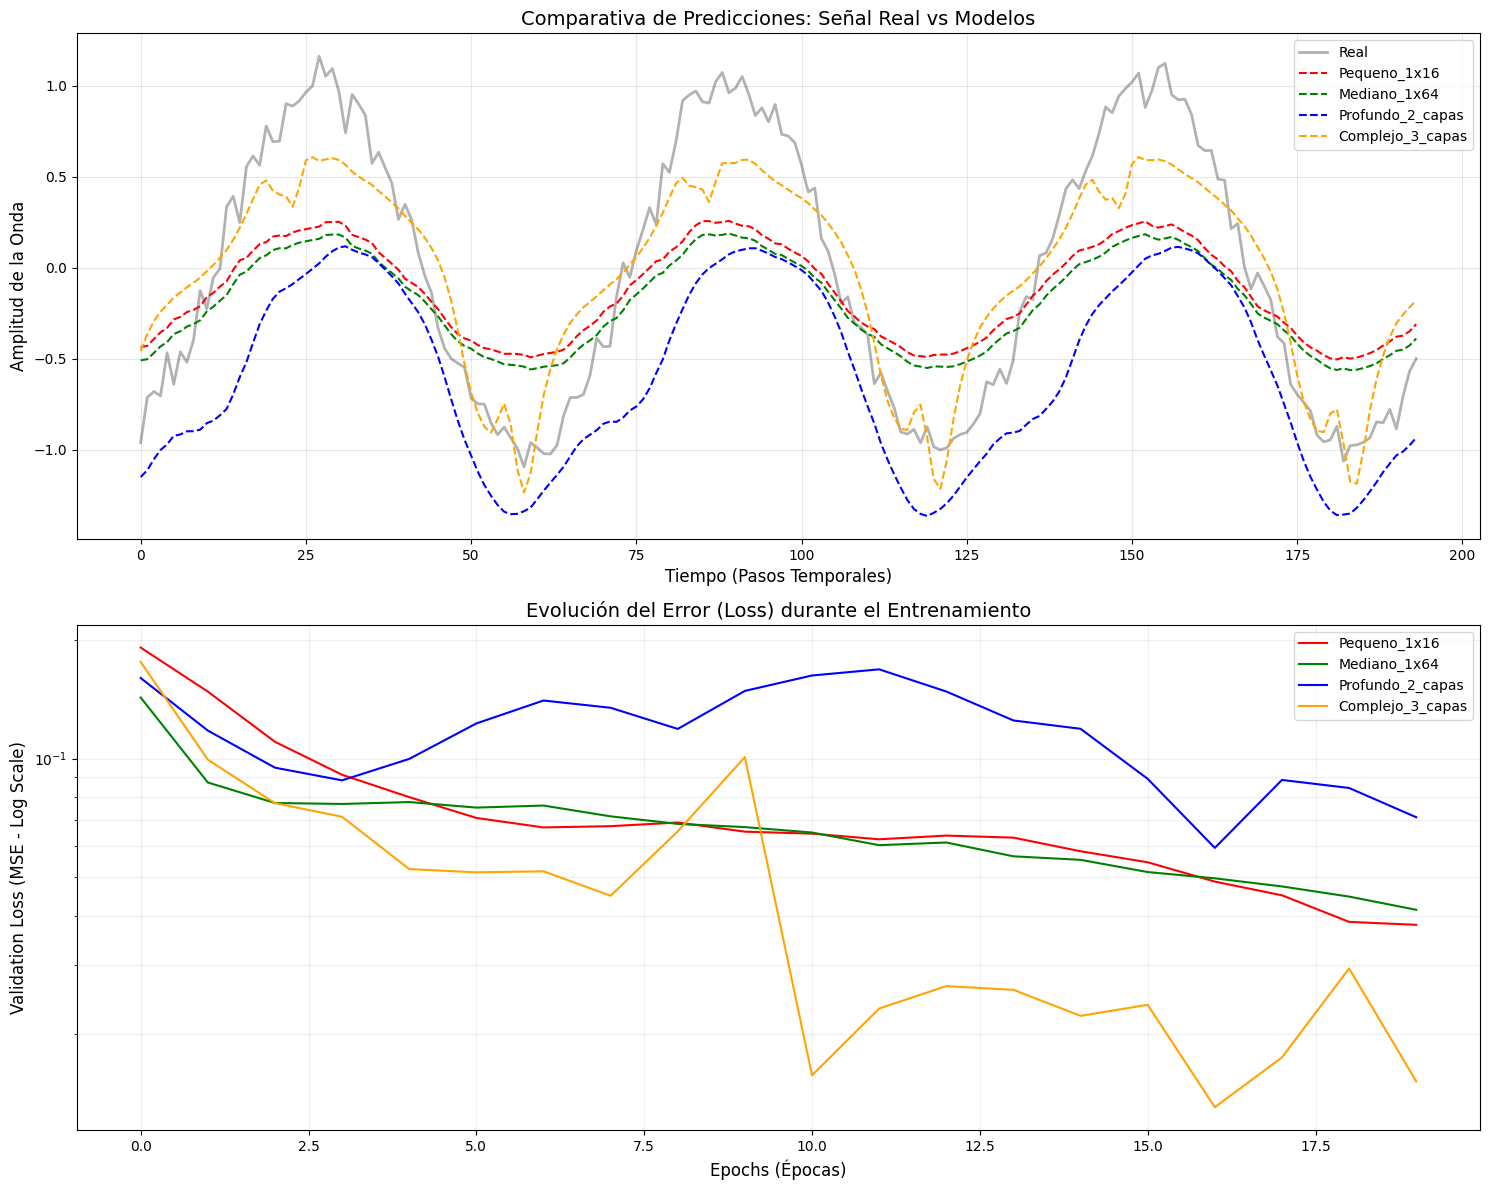

In [28]:
# Gráficos de resultados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# --- Gráfico 1: Predicciones ---
ax1.plot(y_test_actual, label='Real', color='black', alpha=0.3, linewidth=2)
for arq in arquitecturas:
    ax1.plot(predictions[arq["name"]], label=arq["name"], color=arq["color"], linestyle='--')

ax1.set_title('Comparativa de Predicciones: Señal Real vs Modelos', fontsize=14)
ax1.set_xlabel('Tiempo (Pasos Temporales)', fontsize=12)
ax1.set_ylabel('Amplitud de la Onda', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- Gráfico 2: Curvas de Aprendizaje ---
for arq in arquitecturas:
    ax2.plot(histories[arq["name"]]['val_loss'], label=arq["name"], color=arq["color"])

ax2.set_title('Evolución del Error (Loss) durante el Entrenamiento', fontsize=14)
ax2.set_xlabel('Epochs (Épocas)', fontsize=12)
ax2.set_ylabel('Validation Loss (MSE - Log Scale)', fontsize=12)
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout() # Ajusta el espaciado para que no se encimen los ejes
plt.show()

In [29]:
# 1. Seleccionamos el último ejemplo del conjunto de prueba
indice_ejemplo = -1  # El último disponible
input_ejemplo = X_test[indice_ejemplo].reshape(1, look_back, 1)
valor_real_escalado = y_test[indice_ejemplo]

# 2. Des-escalamos el valor real para entenderlo
valor_real = scaler.inverse_transform([[valor_real_escalado]])[0][0]

print(f"--- Prueba de Predicción Individual ---")
print(f"Valor Real (Objetivo): {valor_real:.4f}\n")

# 3. Pedimos a cada modelo su "opinión"
for arq in arquitecturas:
    # Recuperamos el modelo por su nombre (necesita estar en el ámbito actual)
    # Nota: Este bloque asume que los modelos se entrenaron en la celda anterior
    # Para hacerlo más robusto, usaremos las predicciones que ya guardamos
    pred_final = predictions[arq["name"]][indice_ejemplo][0]
    error = abs(valor_real - pred_final)

    print(f"Modelo: {arq['name']}")
    print(f"  > Predicción: {pred_final:.4f}")
    print(f"  > Error Absoluto: {error:.4f}")
    print("-" * 30)

--- Prueba de Predicción Individual ---
Valor Real (Objetivo): -0.4994

Modelo: Pequeno_1x16
  > Predicción: -0.3105
  > Error Absoluto: 0.1889
------------------------------
Modelo: Mediano_1x64
  > Predicción: -0.3890
  > Error Absoluto: 0.1104
------------------------------
Modelo: Profundo_2_capas
  > Predicción: -0.9340
  > Error Absoluto: 0.4345
------------------------------
Modelo: Complejo_3_capas
  > Predicción: -0.1799
  > Error Absoluto: 0.3195
------------------------------


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("--- EVALUACIÓN COMPARATIVA DE RENDIMIENTO ---")
print(f"{'Modelo':<20} | {'MSE (Error)':<12} | {'MAE (Error)':<12} | {'R2 (Ajuste)':<12}")
print("-" * 65)

for arq in arquitecturas:
    nombre = arq["name"]
    # Datos reales vs predicción del modelo correspondiente
    y_true = y_test_actual
    y_pred = predictions[nombre]

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred) # El R2 indica qué tan bien explica el modelo la varianza

    print(f"{nombre:<20} | {mse:<12.5f} | {mae:<12.5f} | {r2:<12.5f}")

print("-" * 65)

--- EVALUACIÓN COMPARATIVA DE RENDIMIENTO ---
Modelo               | MSE (Error)  | MAE (Error)  | R2 (Ajuste) 
-----------------------------------------------------------------
Pequeno_1x16         | 0.22600      | 0.41799      | 0.55949     
Mediano_1x64         | 0.24670      | 0.42711      | 0.51914     
Profundo_2_capas     | 0.42344      | 0.58036      | 0.17464     
Complejo_3_capas     | 0.09067      | 0.25457      | 0.82327     
-----------------------------------------------------------------
